The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


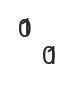

In [46]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
sns.set_palette(get_palette('gnuplot2_r', 2))

In [17]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230418_nepdb_aligned.csv')
cedar_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_expr = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

# (230721) Rank preds + pruning

In [3]:
df = pd.read_csv('../output/230721_TrainDataPruning/total_df.csv')

for evalset in ['KCV', 'PRIME', 'NEPDB']:
    tmp = df.query('evalset==@evalset')
    cdt='not (pruned==False and condition!=1)'
    tmp = tmp.query(cdt)
    
    display(tmp.rename(columns = {'condition':'%Rank'}).groupby(['pruned','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False))

mean_auc
pruned evalset %Rank          
True   KCV     13     0.731816
               11     0.731722
               15     0.731674
               9      0.731373
               12     0.731219
               14     0.731040
               10     0.730974
               8      0.730384
               7      0.729181
               4      0.728816
               6      0.728388
               3      0.727994
               5      0.727935
               2      0.727168
               1      0.725480
False  KCV     1      0.718244

mean_auc
pruned evalset %Rank          
False  PRIME   1      0.720532
True   PRIME   1      0.719105
               2      0.718385
               3      0.716998
               4      0.715391
               5      0.711619
               6      0.711025
               7      0.710781
               9      0.709100
               8      0.708660
               10     0.706624
               11     0.706515
               12     0.705802
               13     0.705609
               15     0.705412
               14     0.705088

mean_auc
pruned evalset %Rank          
False  NEPDB   1      0.807481
True   NEPDB   4      0.794039
               1      0.794025
               2      0.791556
               3      0.789349
               5      0.787376
               6      0.786638
               8      0.785915
               7      0.785426
               9      0.784457
               10     0.782909
               11     0.781232
               13     0.780582
               12     0.778299
               14     0.775403
               15     0.768257

In [4]:
%ls ../output/230721_TrainDataPruning/

bootstrapping/ raw/           total_df.csv


In [7]:
preds_100k = pd.read_csv('../data/human_proteome/preds_100k.txt', header=None)
pruned = pd.read_csv('../output/230721_TrainDataPruning/raw/KCV_preds_PruningTrue_Percentile_05.csv')
pruned.head()

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,...,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input,ratio_rank_squared,mean_pred
0,AAAAAAQQIQV,HLA-B0702,3.9712,0,5,1.0441,1.0441,4.41098,4.411,2.942,...,26.7692,AAAAAAQQLQV,0.0,11.133129,False,False,73978,AAAAAAQQI,15.104329,0.091868
1,AAAAQQIQV,HLA-A0201,1.9555,0,5,2.2847,2.2847,4.41098,4.411,2.942,...,1.9555,AAAAQQLQV,0.0,0.281766,False,False,83295,AAAAQQIQV,1.673734,0.126617
2,AAAAQQIQV,HLA-B0702,4.9092,0,5,4.7746,4.7746,4.41098,4.411,2.942,...,4.9092,AAAAQQLQV,0.0,0.138394,False,False,73978,AAAAQQIQV,5.047594,0.128013
3,AAHFTVLLY,HLA-A1101,0.4196,0,6,0.5881,0.5881,8.35072,8.351,1.194,...,0.4196,AAHFTALLY,0.0,0.120222,False,False,74135,AAHFTVLLY,0.299378,0.341299
4,AAIAASRSV,HLA-C1203,0.0591,0,6,1.1729,1.1729,20.89090,20.891,4.178,...,0.0591,AAIAASRSA,0.0,0.056122,True,True,94776,AAIAASRSV,0.002978,0.240065


In [15]:
def get_misclassified(pred, label, bot, top):
    if pred<bot and label == 1:
        return 'FN'
    if pred>top and label == 0:
        return 'FP'
    else:
        return 'Normal'
percentile_thr = 5
bot, top = [percentile_thr/100, (100-percentile_thr)/100]
bot, top = preds_100k.describe(percentiles=[bot, top]).loc[[f'{bot:.0%}', f'{top:.0%}']].values

pruned['class'] = pruned.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top), axis=1)
pruned['misclassified'] = pruned['class'] != 'Normal'

(pruned.groupby(['fold','misclassified']).agg(count=('Peptide','count')) / pruned.groupby(['fold']).agg(count=('Peptide','count'))).sort_values('count', ascending=False)

,,count
fold,misclassified,
5,False,0.794425
0,False,0.790780
8,False,0.778157
6,False,0.774295
1,False,0.765306
9,False,0.764706
2,False,0.757475
4,False,0.748344
3,False,0.717949


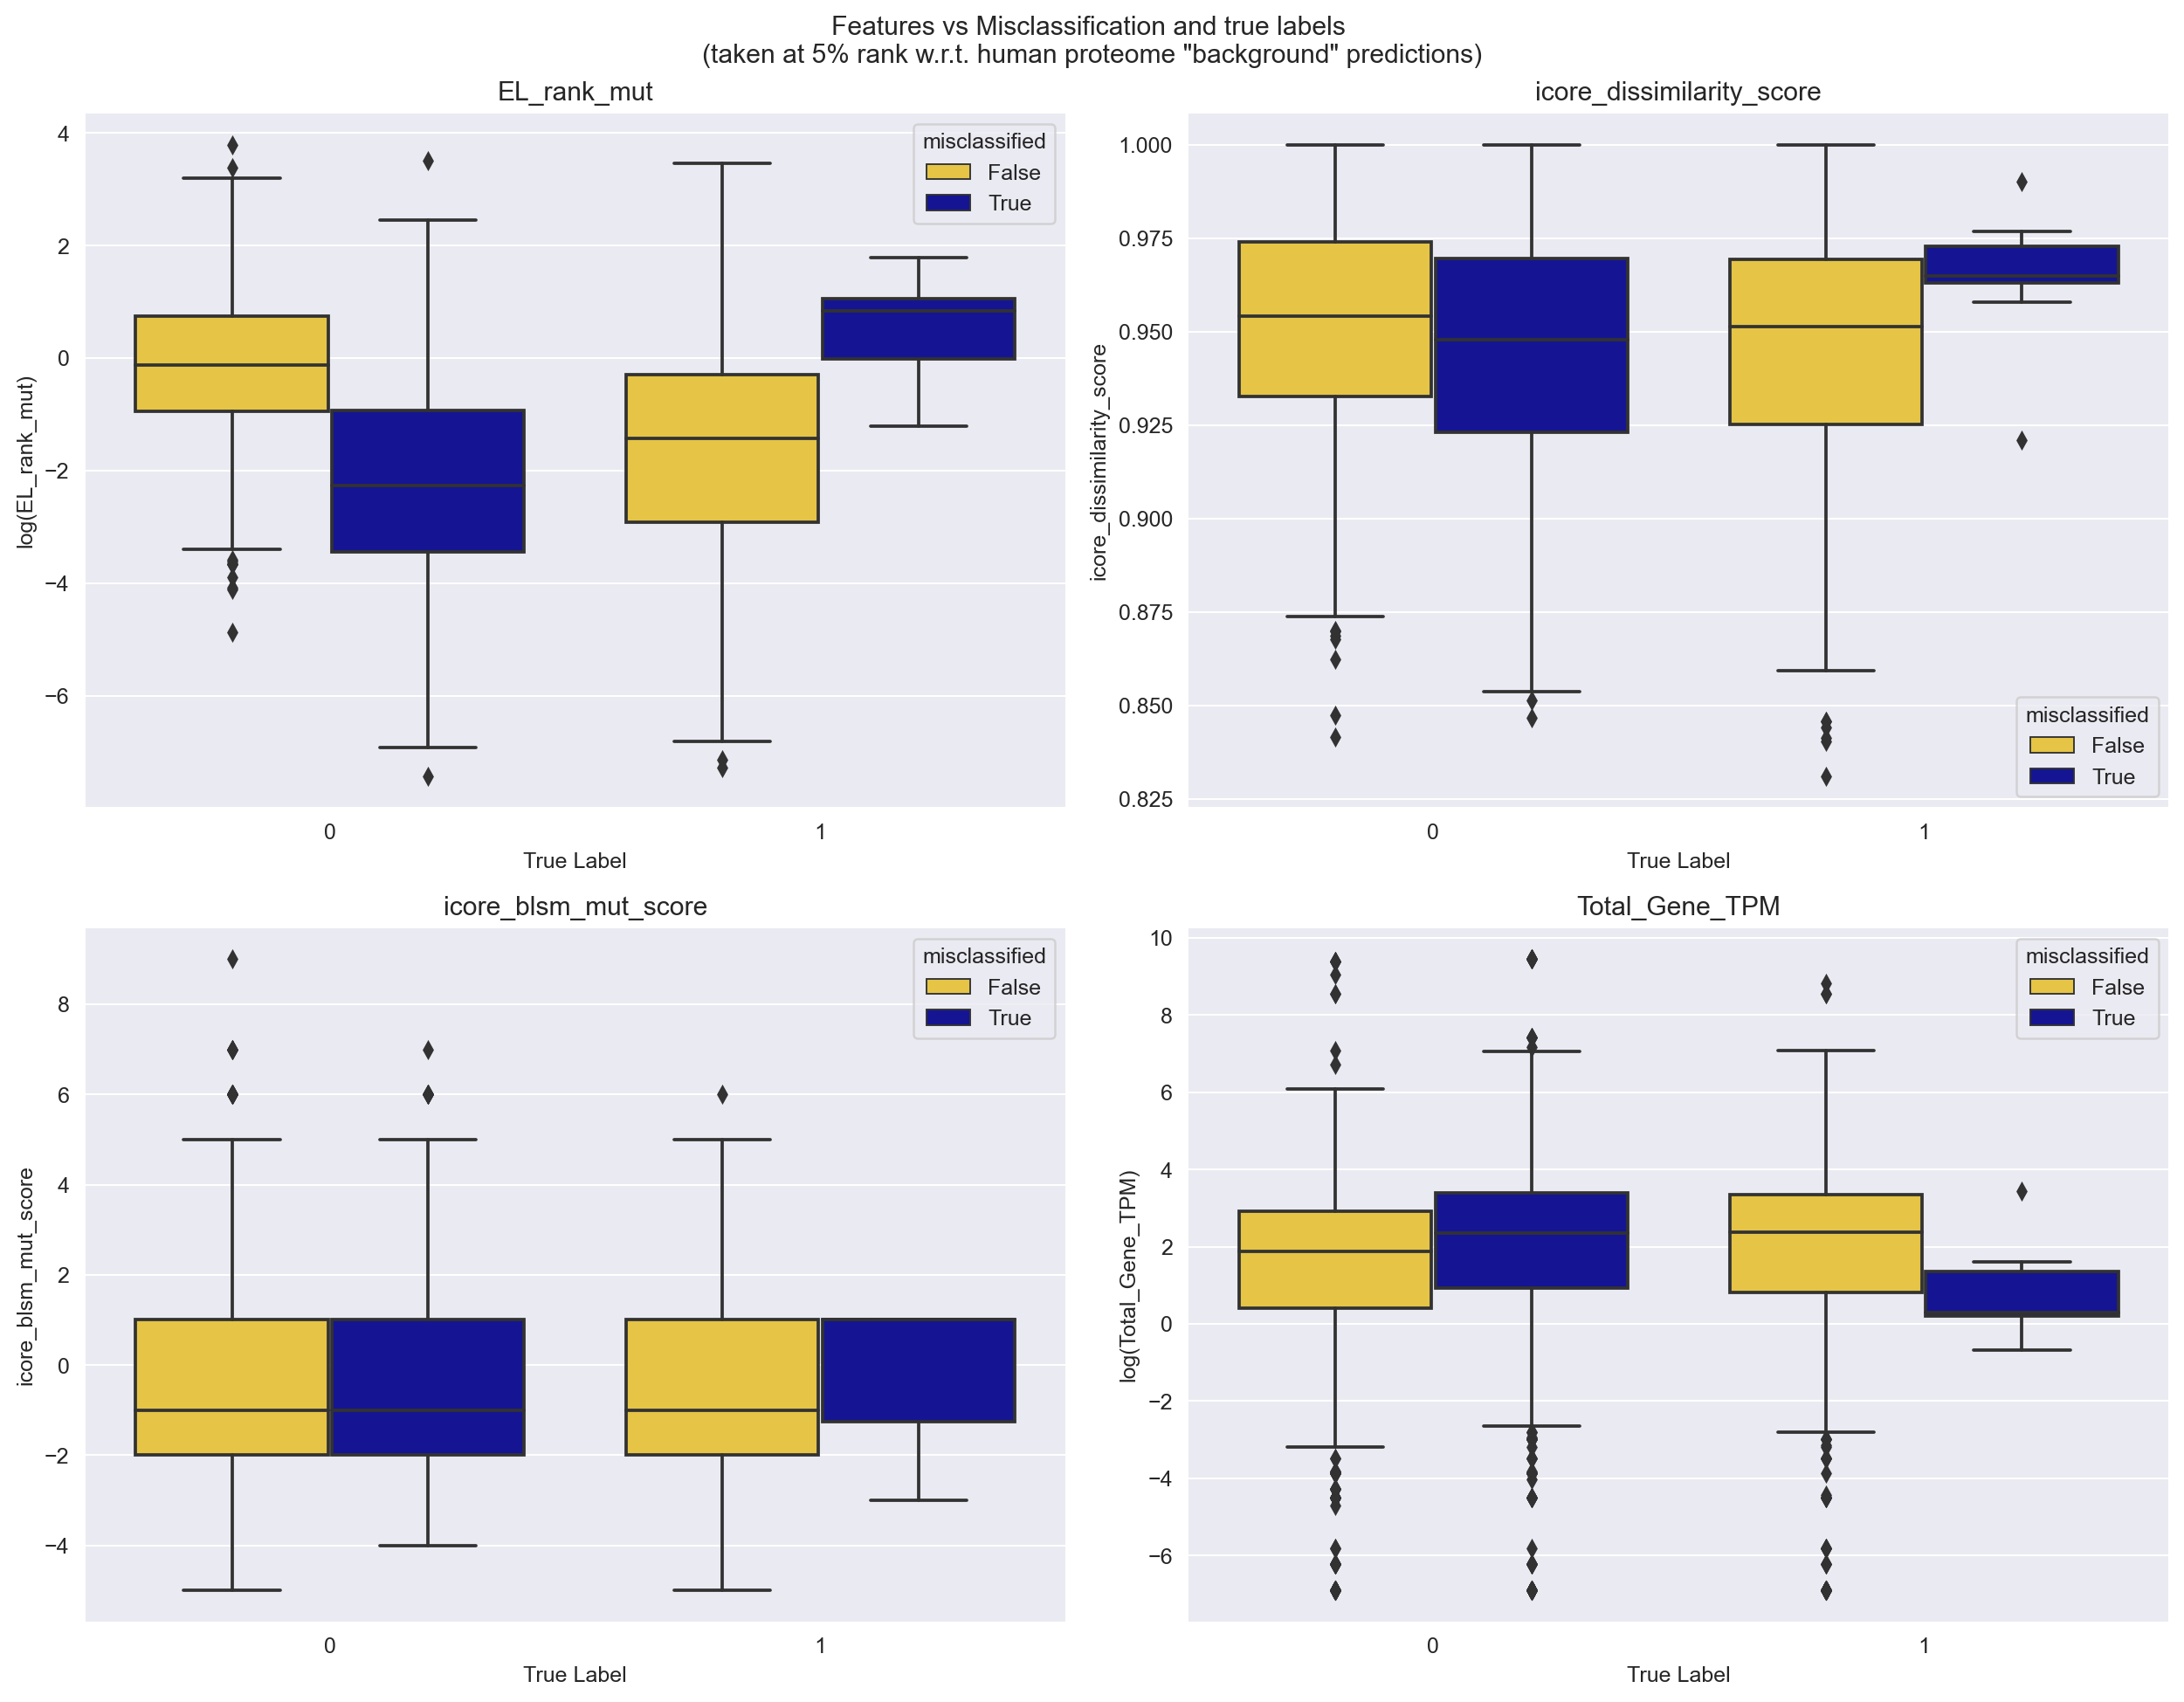

In [58]:
# folds 3,4,7 most misclassified at 28.2, 29.4, 25.1%
pruned['selected'] = pruned.apply(lambda x: x['fold'] in [3,4,7] and x['misclassified'], axis=1)#.query('fold in [3,4,7] and misclassified')
fig,a = plt.subplots(2,2, figsize=(14,11))
a = a.ravel()
for i,f in enumerate(['EL_rank_mut', 'icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM']):
    if 'score' not in f:
        pruned['tmp'] = pruned[f].apply(np.log)
        lab = f'log({f})'
    else:
        pruned['tmp'] = pruned[f]
        lab=f
    sns.boxplot(data = pruned, hue='misclassified', x='agg_label', y='tmp', ax=a[i])
    a[i].set_title(f)#.groupby(['label']).plot(kind='hist', density=True)
    a[i].set_xlabel('True Label')
    a[i].set_ylabel(lab)
fig.suptitle('Features vs Misclassification and true labels \n(taken at 5% rank w.r.t. human proteome "background" predictions)')
fig.tight_layout()
# Seems like the misclassified points have lower rank, lower ratio rank, and higher TPM than the properly classified (for false positives)
# And the opposite for the false negatives
# So maybe check the feature importances ; But seems like the problem here comes from the extra features ? 
# Should check whether the same datapoints are misclassified for the base model -> change script